# Traffic sign detection and classification (with deep learning)
Reset kernel

In [22]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Dependencies
Install dependencies. Adapt this to your linux distro/windows machine. Don't forget to restart the kernel to update the installed python packages.

In [2]:
# %%capture
# # Adapt adp-get to your distro
# !pip install -U jupyter
# !apt-get update && DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv unzip
# !pip install opencv-python torchvision torchaudio albumentations kaggle tdqm torchsummary seaborn
# !pip install --upgrade --quiet jupyter_client ipywidgets torchmetrics
# !jupyter nbextension enable --py widgetsnbextension

Download dataset. I've created an account for this task, so please don't abuse this API key, thx.

In [3]:
# # %%capture
# !mkdir -p ~/.kaggle
# !echo "{\"username\":\"vcguy2022\",\"key\":\"58a013ff978771be5b85417b3ee3917c\"}"  > /root/.kaggle/kaggle.json
# !kaggle datasets download andrewmvd/road-sign-detection
# !unzip road-sign-detection -d dataset/;

In [4]:
# !kaggle datasets download ifigotin/imagenetmini-1000
# !unzip imagenetmini-1000 -d imagenet-mini/;

In [3]:
import albumentations as A
import cv2 as cv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import xml.etree.ElementTree as ET
import pandas as pd

from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy
from torchsummary import summary
from torchvision import models
from tqdm import tqdm

Define your images and annotations directory here

In [4]:
images_directory = "dataset/images"
annotations_directory = "dataset/annotations"

Load train and val images and shuffle them

In [5]:
# Get train and validation datasets
images_directory = "dataset/images"
annotations_directory = "dataset/annotations"

train_split = 0.8

with open("train.txt") as train:
    train_images_filenames_total = train.read().splitlines()

    split_idx = int(train_split * len(train_images_filenames_total))
    train_images_filenames = train_images_filenames_total[:split_idx]
    val_images_filenames = train_images_filenames_total[split_idx:]


with open("test.txt") as test:
    test_images_filenames = test.read().splitlines()

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
test_images_filenames = [i for i in test_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)
random.shuffle(val_images_filenames)
random.shuffle(test_images_filenames)

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

490 123 264


Define functions to visualize images

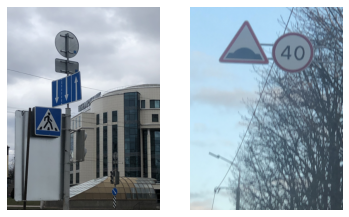

In [6]:
def importImage(name):
    from os import path
    image = cv.imread(path.join(images_directory, name + ".png"))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def displayImage(*names, title=""):
    fig, axs = plt.subplots(nrows=1, ncols=len(names))
    for index, name in enumerate(names):
        axs[index].imshow(importImage(name))
        axs[index].axis('off')
    
    plt.title(title)
    plt.show()

displayImage(train_images_filenames[0], val_images_filenames[0])

## Load Dataset

For this, we define the classes that we want to predict and we define a dataset class, show bellow. It is assumed that all images have at least one sign, and as such, in the data augmentation section, no cropping transformations will be made.

In [7]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self.get_max_area_class_from_annotion(image_filename)

    def get_max_area_class_from_annotion(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]

Define simple transforms that normalize each image for each model

In [8]:
def transform_normalize(input_size, mean, std):
    train_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
        #A.RandomResizedCrop(input_size, input_size),
        #A.HorizontalFlip(),
    return train_transform, val_transform


Define batch size and num workers

In [9]:
batch_size = 64
num_workers = 0 # How many processes are used to load the data

Get dataloaders according to desired image size, which will vary according to the expected input size of the network

In [10]:
def get_dataloaders(input_size, mean, std, transform_f):
    train_transform, val_transform = transform_f(input_size, mean, std)
    train_dataset = TrafficSignDataset(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    # Apply same transform for validation and test
    val_dataset = TrafficSignDataset(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

    test_dataset = TrafficSignDataset(annotations_directory, test_images_filenames, images_directory, transform=val_transform)
    test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train_dataloader, val_dataloader, test_dataloader

Define device

In [11]:
num_classes = len(classes)

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Training

We define a model trainer class, which will help us to train each model more easily. This class trains a model for a given number of epochs, keeps track of the accuracy and loss of the model accross all epochs, and can save or load the model anytime

In [12]:
MODELS_DIR = "models"

class ModelTrainer:
    def __init__(self, *args):
        if len(args) == 5:
            model, model_name, loss, optimizer, device = args
        elif len(args) == 2:
            ks = ["model", "name", "num_epochs", "loss", "optimizer"]
            model, model_name, num_epochs, loss, optimizer = [args[0][k] for k in ks]
            device = args[1]

        self.model = model
        self.model_name = model_name
        self.curr_epoch = 0
        self.num_epochs = num_epochs # Epochs that each training session will have
        self.loss = loss
        self.optimizer = optimizer
        self.device = device
        self.scheduler = None
        self.accuracies = {}

    def predict_data(self, data):
        print("Predicting data")
        preds = []
        actuals = []
        with torch.set_grad_enabled(False):
            for _, (X, y) in enumerate(tqdm(data)):
                pred = self.model(X)
                probs = F.softmax(pred, dim=1)
                final_pred = self.activation_out(probs)
                preds.extend(final_pred)
                actuals.extend(y)
        return torch.stack(preds, dim=0), torch.stack(actuals, dim=0)

    def _epoch_iter(self, dataloader, is_train, progress_bar=False):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            data = tqdm(dataloader) if progress_bar else dataloader
            for batch, (X, y) in enumerate(data):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred.cpu().numpy())
                labels.extend(y.cpu().numpy())

        metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        # metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        return total_loss / num_batches, metrics
    
    def _save_model(self, t, file_name):
        import os
        os.makedirs(MODELS_DIR, exist_ok=True)

        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        
        save_dict = {'model': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_path)

        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        with open(acc_path, 'w') as f:
            f.write(json.dumps(self.accuracies))

    def load_model(self, file_name):
        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        dic = torch.load(model_path)
        self.model.load_state_dict(dic['model'])
        self.model.eval()
        
        with open(acc_path, 'r') as f:
            self.accuracies = json.load(f)

        print(f"Loaded { self.model_name } obtained in epoch { dic['epoch'] }")

    def append_history(self, stage, train_data, val_data):
        train_loss, train_metrics = train_data
        val_loss, val_metrics = val_data
        self.accuracies[stage] = {
            "train": {
                "loss": train_loss,
                "metrics": train_metrics
            },
            "val": {
                "loss": val_loss,
                "metrics": val_metrics
            },         
        }

    def reset_accuracy(self):
        self.accuracies = {}
    
    def get_best_score(self):
        def get_score(node):
            return node["val"]["metrics"]["accuracy"]
        
        m_acc, m_stage = 0, ""
        for stg in self.accuracies:
            acc = get_score(self.accuracies[stg])
            if acc > m_acc:
                m_acc = acc
                m_stage = stg
        return m_acc, m_stage

    def set_scheduler(self, scheduler, gamma):
        if scheduler != None:
            self.scheduler = scheduler(self.optimizer, gamma)

    def train(self, train_dataloader, validation_dataloader, stage, progress_bar=False):
        # Stage => String identifier of the training iteration. Is used to identify between
        # the same model being trained at different contexts (exº fine tunning)
        accuracies = []
        train_history = {'loss': [], 'accuracy': []}
        val_history = {'loss': [], 'accuracy': []}
        best_val_loss = np.inf
        print("Start training...")

        for _ in range(self.num_epochs):
            t = self.curr_epoch
            print(f"\nEpoch {t}", end=" - ")

            # Train
            train_loss, train_metrics = self._epoch_iter(train_dataloader, True, progress_bar)
            train_acc = train_metrics["accuracy"]

            print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}", end=" - ")

            # Test
            val_loss, val_metrics = self._epoch_iter(validation_dataloader, False, progress_bar)
            val_acc = val_metrics["accuracy"]
            print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")
            
            # If scheduler exists, update lr
            if self.scheduler != None:
                self.scheduler.step()

            # save training history for plotting purposes
            self.append_history(
                f'{stage}_{t}',
                (train_loss, train_metrics),
                (val_loss, val_metrics)
            )

            # Save model when validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model(f'{stage}_{t}', 'best_model')

            # Save latest model
            self._save_model(f'{stage}_{t}', 'latest_model')
            self.curr_epoch += 1
            
        print("Finished")

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_fc(self):
        if hasattr(self.model, 'classifier'):
            last_item_index = len(self.model.classifier)-1
            layer = self.model.classifier.__getitem__(last_item_index)
            layer.weight.requires_grad = True
        elif hasattr(self.model, 'fc'):
            self.model.fc.weight.requires_grad = True

    def test(self, test_dataloader):
        self.model.eval()
        preds = []
        actuals = []
        
        with torch.no_grad():
            for batch, (X, y) in enumerate(test_dataloader):
                X, y = X.to(self.device), y.to(self.device)

                pred = self.model(X)
                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred.cpu().numpy())
                actuals.extend(y.cpu().numpy())
        
        metrics = classification_report(actuals, preds, output_dict=True, zero_division=0)
        return metrics

The function bellow will plot the accuracy and loss of a training session

In [13]:
def plotTrainingHistory(accuracies, session):
    session_accs = filter(lambda x: x.startswith(session), accuracies)
    val_loss, val_acc, train_loss, train_acc = [], [], [], []
    classes_pre = {c:[] for c in classes}
    for t in session_accs:
        epoch_acc = accuracies[t]
        train_loss.append(epoch_acc["train"]["loss"])
        train_acc.append(epoch_acc["train"]["metrics"]["accuracy"])
        val_loss.append(epoch_acc["val"]["loss"])
        val_acc.append(epoch_acc["val"]["metrics"]["accuracy"])
        for c in classes_pre:
            pre = epoch_acc["val"]["metrics"][str(classes[c])]["precision"]
            classes_pre[c].append(pre)

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend(loc='best')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.legend(loc='best')
    plt.show()

    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(20)
    plt.subplot(4, 1, 2)
    plt.title('Per Class Precision')
    for c in classes:  
        plt.plot(classes_pre[c], label=c)
    plt.legend(loc='best')
    plt.show()

And the function bellow will be used to try and load an existing model so that we don't have to retrain it when running the notebook

In [14]:
def load_model(trainer): # Returns True if success
    import os
    path = os.path.join(MODELS_DIR, trainer.model_name + '_best_model.pth')
    file_exists = os.path.exists(path)
    if not file_exists:
        print("Saved model not found, training instead.")
        return False
    else:
        trainer.load_model("best_model")
        return True


### ResNet-50
ResNet-50 expects an input size of 224, and expects images to be normalized according to the following mean and std values. We use these values to retrieve the dataloaders. In this initial setup, we will only normalize each image. Data augmentation will be tinkered with later.

In [15]:
input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(input_size, mean, std, transform_normalize)

Charactarize training and validation sets

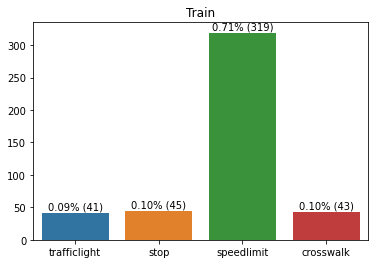

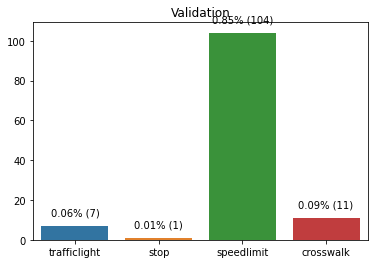

In [16]:
def describe_dataloader(dataloader, title):
    train_vals = np.array([])
    for batch, (X, y) in enumerate(dataloader):
        train_vals = np.append(train_vals, y.numpy())

    freqs = {c:np.count_nonzero(train_vals == classes[c]) for c in classes}
    keys = list(freqs.keys())
    vals = [int(freqs[k]) for k in keys]
    s = sum(vals)
    labels = [val / s for val in vals]
    labels = [f"{labels[i]:.2f}% ({vals[i]})" for i in range(len(labels))]
    ax = sns.barplot(x=keys, y=vals)
    patches = ax.patches
    ax.set_title(title)
    for i in range(len(patches)):
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+5
        ax.annotate(labels[i], (x, y), ha='center')
    plt.show()

describe_dataloader(train_dataloader, "Train"), describe_dataloader(val_dataloader, "Validation");

As can be seen, the speedlimit class is clearly the most predominant sign with the highest area across all images. This predominance is present on both validation and train sets. 

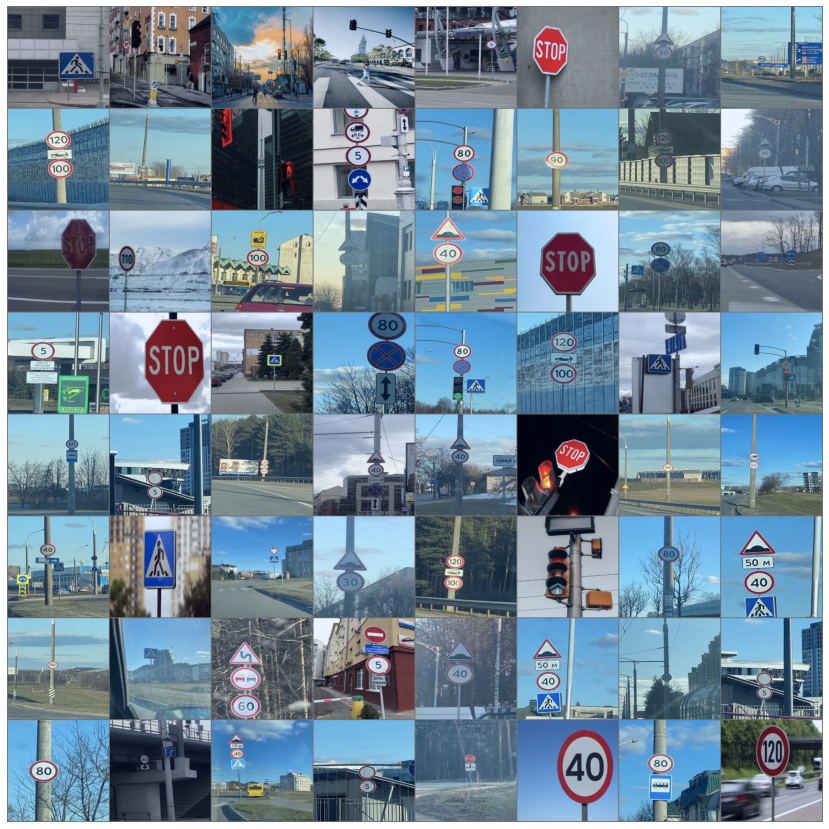

In [15]:
dataiter = iter(train_dataloader)
sample = dataiter.next()[0]

grid = torchvision.utils.make_grid(sample).permute(1, 2, 0).numpy()
grid += abs(np.amin(grid))
grid /= np.amax(grid)

plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(grid)
plt.show()

#### Transfer Learning

We define a pretrained ResNet-50 as our baseline, with 10 epochs, cross entropy loss, and SGD optimizer. We will compare all models with this one.

In [17]:
resnet_model_trained = models.resnet50(pretrained=True)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_trained.fc.in_features
resnet_model_trained.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_trained.to(device)

resnet_trained = {
    "model": resnet_model_trained,
    "name": 'resnet50_pretrained',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-2),
}

#summary(resnet["model"], (3, input_size, input_size))

First we do **transfer learning** - train only the last layer while freezing all others.

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 0.980 	 Train acc: 0.685 - Val loss: 0.611 	 Val acc: 0.846

Epoch 1 - Train loss: 0.856 	 Train acc: 0.703 - Val loss: 0.633 	 Val acc: 0.846

Epoch 2 - Train loss: 0.797 	 Train acc: 0.708 - Val loss: 0.589 	 Val acc: 0.846

Epoch 3 - Train loss: 0.711 	 Train acc: 0.728 - Val loss: 0.535 	 Val acc: 0.854

Epoch 4 - Train loss: 0.675 	 Train acc: 0.752 - Val loss: 0.493 	 Val acc: 0.846

Epoch 5 - Train loss: 0.639 	 Train acc: 0.763 - Val loss: 0.482 	 Val acc: 0.862

Epoch 6 - Train loss: 0.600 	 Train acc: 0.781 - Val loss: 0.496 	 Val acc: 0.870

Epoch 7 - Train loss: 0.574 	 Train acc: 0.815 - Val loss: 0.450 	 Val acc: 0.862

Epoch 8 - Train loss: 0.523 	 Train acc: 0.806 - Val loss: 0.465 	 Val acc: 0.894

Epoch 9 - Train loss: 0.505 	 Train acc: 0.837 - Val loss: 0.436 	 Val acc: 0.878
Finished


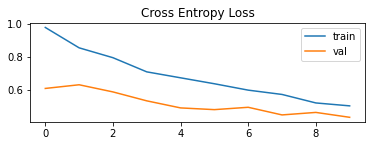

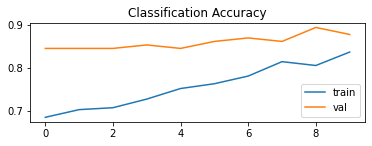

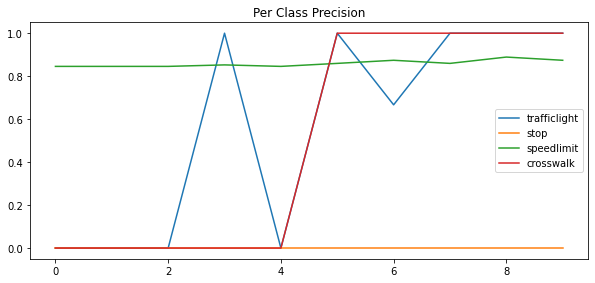

In [21]:
resnet_trainer = ModelTrainer(resnet_trained, device)
# Unfreeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = True # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)
if not load or need_train:
    need_train = True
    resnet_trainer.train(train_dataloader, val_dataloader, "frozen")

plotTrainingHistory(resnet_trainer.accuracies, "frozen")

In [22]:
res = resnet_trainer.test(test_dataloader)
pd.DataFrame.from_dict(res)

,0,1,2,3,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.873950,1.000000,0.878049,0.718487,0.885291
recall,0.285714,0.0,1.000000,0.181818,0.878049,0.366883,0.878049
f1-score,0.444444,0.0,0.932735,0.307692,0.878049,0.421218,0.841465
support,7.000000,1.0,104.000000,11.000000,0.878049,123.000000,123.000000


We can see that the model can distinguish most of the speedlimit signs, while not knowing how to deal with crosswalks or trafficlights. During the last epochs the model seems to have learned how to identify stop signs.

Perform **fine tunning** - unfreeze all layers and train with a small learning rate a small number of epochs. We expect better fine tuned results after this.

Start training...

Epoch 10 - Train loss: 0.494 	 Train acc: 0.828 - Val loss: 0.436 	 Val acc: 0.870

Epoch 11 - Train loss: 0.488 	 Train acc: 0.846 - Val loss: 0.436 	 Val acc: 0.870

Epoch 12 - Train loss: 0.487 	 Train acc: 0.839 - Val loss: 0.436 	 Val acc: 0.878
Finished


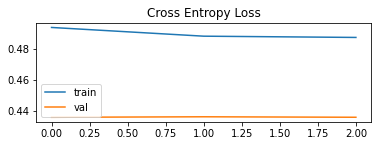

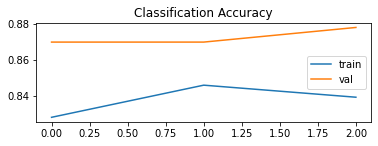

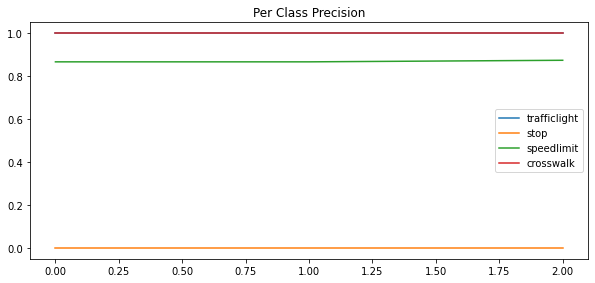

In [23]:
resnet_trainer.optimizer = torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-6)
resnet_trainer.num_epochs = 3 
resnet_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    resnet_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistory(resnet_trainer.accuracies, "fine_tuning")

In [24]:
res = resnet_trainer.test(test_dataloader)
pd.DataFrame.from_dict(res)

,0,1,2,3,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.873950,1.000000,0.878049,0.718487,0.885291
recall,0.285714,0.0,1.000000,0.181818,0.878049,0.366883,0.878049
f1-score,0.444444,0.0,0.932735,0.307692,0.878049,0.421218,0.841465
support,7.000000,1.0,104.000000,11.000000,0.878049,123.000000,123.000000


As we can see, our best result was 0.754, which we consider satisfactory as the learning rate is fixed and we are applying few data augmentation. In addition, fine tunning has given the model the capability to distinguish crosswalk signs, but traffic lights are still not being detected.

Now let's bundle this into a function that does the transfer learning process

In [18]:
def transfer_learn(name, model,
                   opt_freeze, lr_freeze, ep_freeze,
                   opt_fine_tune, lr_fine_tune, ep_fine_tune,
                   load,
                   scheduler_freeze=None, scheduler_fine_tune=None,
                   scheduler_gamma_freeze=None, scheduler_gamma_fine_tune=None):

    # change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
    if hasattr(model, 'classifier'): # VGG 
        last_item_index = len(model.classifier)-1
        old_fc = model.classifier.__getitem__(last_item_index)
        new_fc = nn.Linear(in_features=old_fc.in_features, out_features= num_classes, bias=True)
        model.classifier.__setitem__(last_item_index , new_fc)
    elif hasattr(model, 'fc'): # Resnet
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model.to(device)

    model_d = {
        "model": model,
        "name": name,
        #"num_epochs": 50,
        "num_epochs": ep_freeze,
        "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
        "optimizer": opt_freeze(model.parameters(), lr=lr_freeze)
    }

    trainer = ModelTrainer(model_d, device)
    trainer.set_scheduler(scheduler_freeze, scheduler_gamma_freeze)
    # Freeze all layers expect last
    trainer.freeze_layers()
    trainer.unfreeze_fc()

    # Training can be skipped by loading the best model until now
    if load:
        need_train = (load_model(trainer) == False)
    if not load or need_train:
        need_train = True
        trainer.train(train_dataloader, val_dataloader, "frozen")

    # Unfreeze all layers - fine tuning
    trainer.optimizer = opt_fine_tune(model.parameters(), lr=lr_fine_tune)
    trainer.set_scheduler(scheduler_fine_tune, scheduler_gamma_fine_tune)
    trainer.num_epochs = ep_fine_tune
    trainer.unfreeze_layers()

    if need_train: # Train if previous cell has trained too
        trainer.train(train_dataloader, val_dataloader, "fine_tuning")

    plotTrainingHistory(trainer.accuracies, "frozen")
    plotTrainingHistory(trainer.accuracies, "fine_tuning")
    res = resnet_trainer.test(test_dataloader)
    return trainer, pd.DataFrame.from_dict(res)


##### **Optimizer Tuning**

Now we will experiment with different optimizers and compare results

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 3.126 	 Train acc: 0.440 - Val loss: 1.584 	 Val acc: 0.846

Epoch 1 - Train loss: 3.462 	 Train acc: 0.712 - Val loss: 1.025 	 Val acc: 0.870

Epoch 2 - Train loss: 1.051 	 Train acc: 0.679 - Val loss: 0.923 	 Val acc: 0.854

Epoch 3 - Train loss: 0.899 	 Train acc: 0.833 - Val loss: 0.492 	 Val acc: 0.821

Epoch 4 - Train loss: 0.382 	 Train acc: 0.866 - Val loss: 0.501 	 Val acc: 0.902

Epoch 5 - Train loss: 0.280 	 Train acc: 0.911 - Val loss: 0.401 	 Val acc: 0.878

Epoch 6 - Train loss: 0.189 	 Train acc: 0.922 - Val loss: 0.420 	 Val acc: 0.902

Epoch 7 - Train loss: 0.200 	 Train acc: 0.922 - Val loss: 0.381 	 Val acc: 0.870

Epoch 8 - Train loss: 0.159 	 Train acc: 0.944 - Val loss: 0.321 	 Val acc: 0.919

Epoch 9 - Train loss: 0.109 	 Train acc: 0.969 - Val loss: 0.339 	 Val acc: 0.911
Finished
Start training...

Epoch 10 - Train loss: 0.094 	 Train acc: 0.975 - Val loss: 0.346 	 Val acc: 0.911


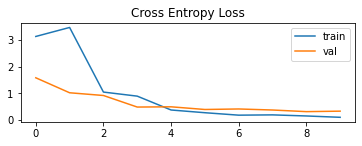

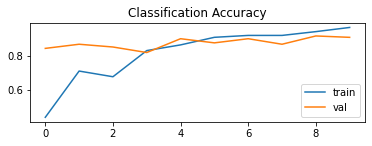

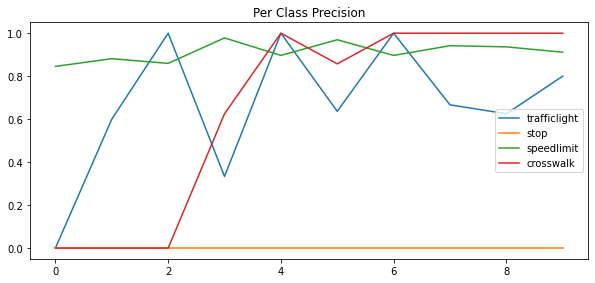

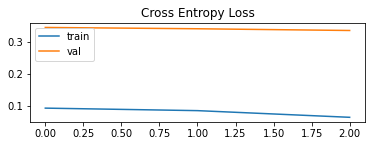

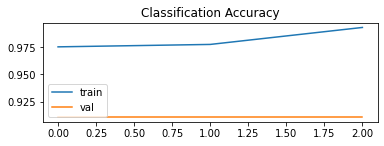

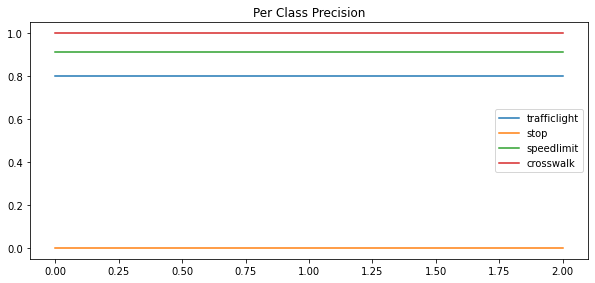

,0,1,2,3,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.873950,1.000000,0.878049,0.718487,0.885291
recall,0.285714,0.0,1.000000,0.181818,0.878049,0.366883,0.878049
f1-score,0.444444,0.0,0.932735,0.307692,0.878049,0.421218,0.841465
support,7.000000,1.0,104.000000,11.000000,0.878049,123.000000,123.000000


In [26]:
# Adam optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer, adam_res = transfer_learn(
    name="resnet50_pretrained_adam",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
adam_res

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 4.137 	 Train acc: 0.513 - Val loss: 2.125 	 Val acc: 0.081

Epoch 1 - Train loss: 1.339 	 Train acc: 0.567 - Val loss: 0.758 	 Val acc: 0.854

Epoch 2 - Train loss: 0.767 	 Train acc: 0.737 - Val loss: 0.385 	 Val acc: 0.935

Epoch 3 - Train loss: 0.472 	 Train acc: 0.830 - Val loss: 0.446 	 Val acc: 0.862

Epoch 4 - Train loss: 0.381 	 Train acc: 0.871 - Val loss: 0.353 	 Val acc: 0.935

Epoch 5 - Train loss: 0.349 	 Train acc: 0.873 - Val loss: 0.353 	 Val acc: 0.894

Epoch 6 - Train loss: 0.311 	 Train acc: 0.900 - Val loss: 0.354 	 Val acc: 0.927

Epoch 7 - Train loss: 0.248 	 Train acc: 0.920 - Val loss: 0.299 	 Val acc: 0.927

Epoch 8 - Train loss: 0.228 	 Train acc: 0.931 - Val loss: 0.327 	 Val acc: 0.935

Epoch 9 - Train loss: 0.229 	 Train acc: 0.935 - Val loss: 0.324 	 Val acc: 0.911
Finished
Start training...

Epoch 10 - Train loss: 0.205 	 Train acc: 0.940 - Val loss: 0.324 	 Val acc: 0.911


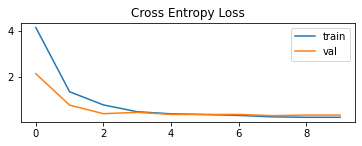

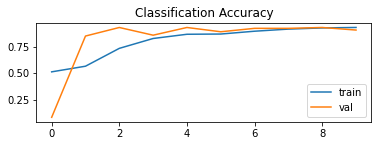

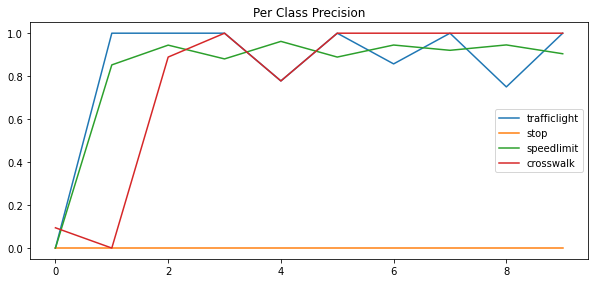

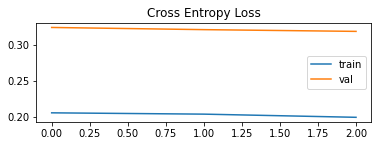

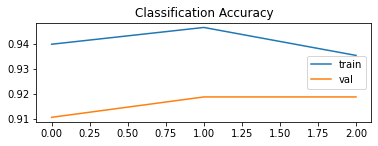

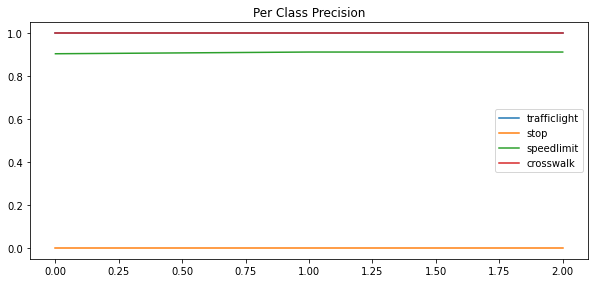

,0,1,2,3,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.873950,1.000000,0.878049,0.718487,0.885291
recall,0.285714,0.0,1.000000,0.181818,0.878049,0.366883,0.878049
f1-score,0.444444,0.0,0.932735,0.307692,0.878049,0.421218,0.841465
support,7.000000,1.0,104.000000,11.000000,0.878049,123.000000,123.000000


In [27]:
# Adamax optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer, adamax_score = transfer_learn(
    name="resnet50_pretrained_adamax",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adamax,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.Adamax,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
adamax_score

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 29.027 	 Train acc: 0.451 - Val loss: 14.658 	 Val acc: 0.211

Epoch 1 - Train loss: 14.943 	 Train acc: 0.556 - Val loss: 4.211 	 Val acc: 0.878

Epoch 2 - Train loss: 4.347 	 Train acc: 0.768 - Val loss: 0.513 	 Val acc: 0.878

Epoch 3 - Train loss: 0.759 	 Train acc: 0.848 - Val loss: 0.688 	 Val acc: 0.919

Epoch 4 - Train loss: 0.650 	 Train acc: 0.877 - Val loss: 0.699 	 Val acc: 0.911

Epoch 5 - Train loss: 0.293 	 Train acc: 0.926 - Val loss: 0.588 	 Val acc: 0.927

Epoch 6 - Train loss: 1.078 	 Train acc: 0.862 - Val loss: 0.731 	 Val acc: 0.911

Epoch 7 - Train loss: 5.771 	 Train acc: 0.670 - Val loss: 2.650 	 Val acc: 0.821

Epoch 8 - Train loss: 1.326 	 Train acc: 0.848 - Val loss: 0.674 	 Val acc: 0.919

Epoch 9 - Train loss: 0.199 	 Train acc: 0.940 - Val loss: 0.592 	 Val acc: 0.919
Finished
Start training...

Epoch 10 - Train loss: 0.153 	 Train acc: 0.949 - Val loss: 0.592 	 Val acc: 0.9

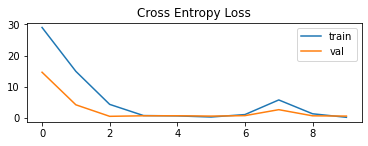

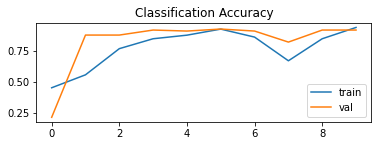

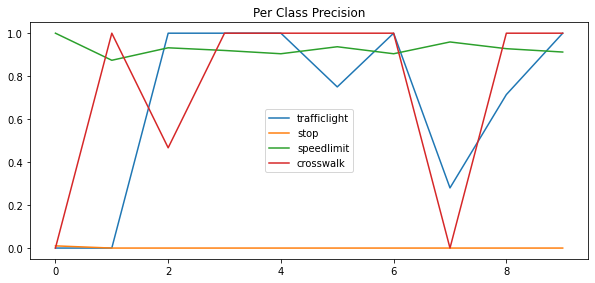

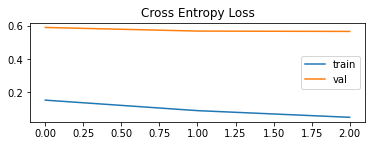

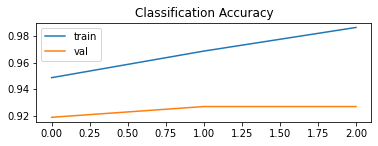

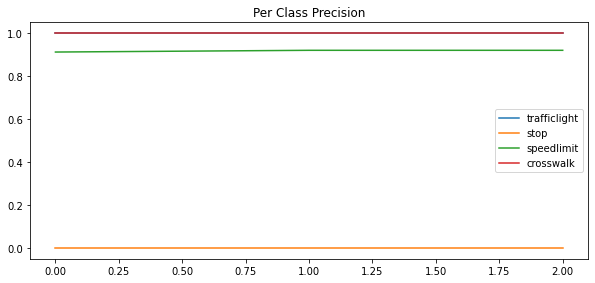

,0,1,2,3,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.873950,1.000000,0.878049,0.718487,0.885291
recall,0.285714,0.0,1.000000,0.181818,0.878049,0.366883,0.878049
f1-score,0.444444,0.0,0.932735,0.307692,0.878049,0.421218,0.841465
support,7.000000,1.0,104.000000,11.000000,0.878049,123.000000,123.000000


In [28]:
# RMSprop optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer, rmsprop_score = transfer_learn(
    name="resnet50_pretrained_rmsprop",
    model=resnet_model_trained,
    opt_freeze=torch.optim.RMSprop,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.RMSprop,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
rmsprop_score

As can be seen, the optimizer that provided the best results was adam. It increased accuracy from 75% to 85%.

#### **Learning Rate Scheduler**

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 3.372 	 Train acc: 0.484 - Val loss: 0.954 	 Val acc: 0.789

Epoch 1 - Train loss: 1.946 	 Train acc: 0.741 - Val loss: 1.276 	 Val acc: 0.756

Epoch 2 - Train loss: 1.149 	 Train acc: 0.770 - Val loss: 0.445 	 Val acc: 0.854

Epoch 3 - Train loss: 0.468 	 Train acc: 0.824 - Val loss: 0.433 	 Val acc: 0.911

Epoch 4 - Train loss: 0.393 	 Train acc: 0.868 - Val loss: 0.387 	 Val acc: 0.902

Epoch 5 - Train loss: 0.253 	 Train acc: 0.913 - Val loss: 0.351 	 Val acc: 0.911

Epoch 6 - Train loss: 0.234 	 Train acc: 0.906 - Val loss: 0.308 	 Val acc: 0.927

Epoch 7 - Train loss: 0.190 	 Train acc: 0.933 - Val loss: 0.315 	 Val acc: 0.927

Epoch 8 - Train loss: 0.169 	 Train acc: 0.944 - Val loss: 0.287 	 Val acc: 0.935

Epoch 9 - Train loss: 0.140 	 Train acc: 0.967 - Val loss: 0.317 	 Val acc: 0.911
Finished
Start training...

Epoch 10 - Train loss: 0.131 	 Train acc: 0.960 - Val loss: 0.315 	 Val acc: 0.911


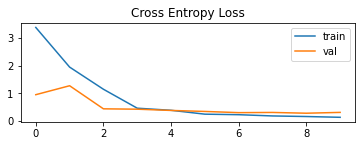

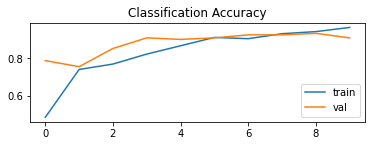

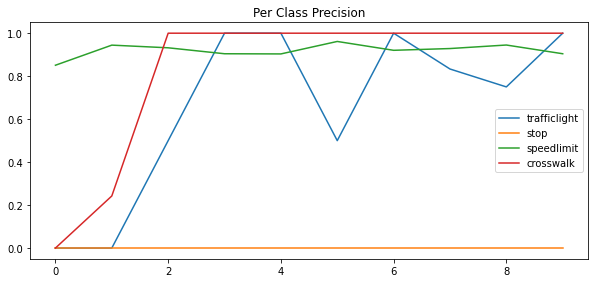

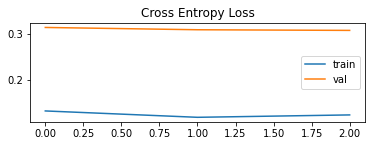

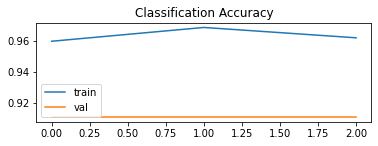

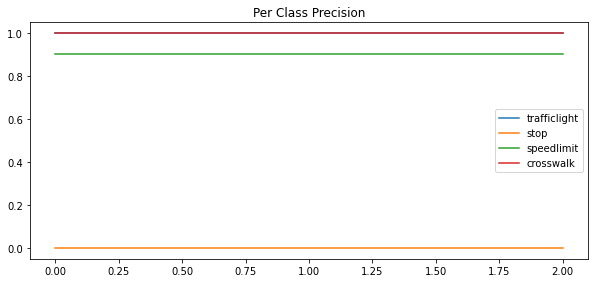

,0,1,2,3,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.873950,1.000000,0.878049,0.718487,0.885291
recall,0.285714,0.0,1.000000,0.181818,0.878049,0.366883,0.878049
f1-score,0.444444,0.0,0.932735,0.307692,0.878049,0.421218,0.841465
support,7.000000,1.0,104.000000,11.000000,0.878049,123.000000,123.000000


In [29]:
# ExpLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer, expLR_score = transfer_learn(
    name="resnet50_pretrained_adam_expLR",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_fine_tune=0.9,
    load=True
)
expLR_score

Loaded resnet50_pretrained_adam_stepLR obtained in epoch fine_tuning_12


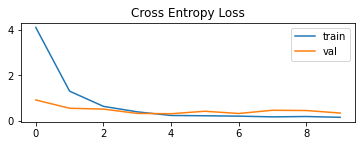

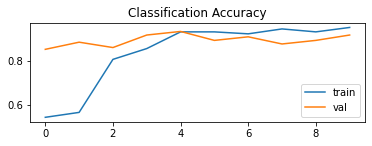

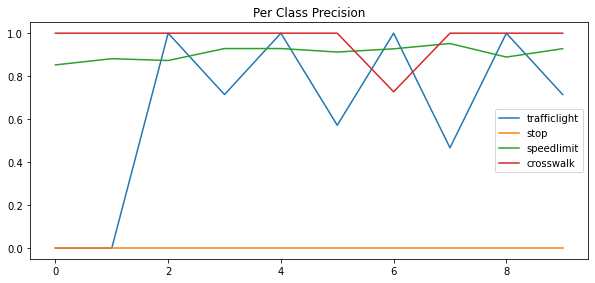

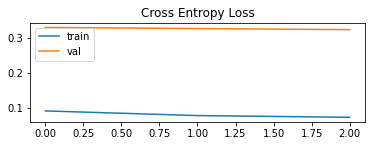

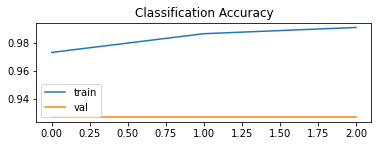

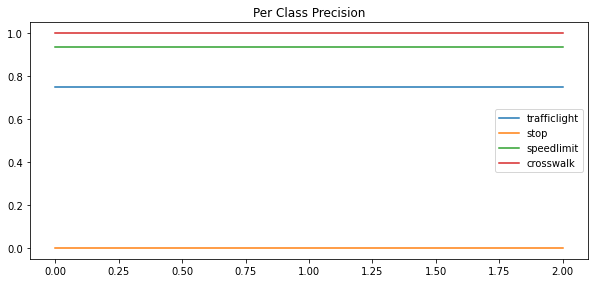

,0,1,2,3,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.873950,1.000000,0.878049,0.718487,0.885291
recall,0.285714,0.0,1.000000,0.181818,0.878049,0.366883,0.878049
f1-score,0.444444,0.0,0.932735,0.307692,0.878049,0.421218,0.841465
support,7.000000,1.0,104.000000,11.000000,0.878049,123.000000,123.000000


In [31]:
# StepLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer, stepLR_best_score = transfer_learn(
    name="resnet50_pretrained_adam_stepLR",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_fine_tune=0.9,
    load=True
)

stepLR_best_score

In [32]:
rmsprop_best_score

NameError: name 'rmsprop_best_score' is not defined

ExpLR had the best results, with an increase of 3% in accuracy

#### Train from scratch

Now let's train the network from **scratch**, with the same hyperparams except learning rate, which was increased to get to the minima faster.

Start training...

Epoch 0 - Train loss: 5.119 	 Train acc: 0.674 - Val loss: 2170711040.000 	 Val acc: 0.089

Epoch 1 - Train loss: 1.785 	 Train acc: 0.679 - Val loss: 75018.246 	 Val acc: 0.089

Epoch 2 - Train loss: 1.450 	 Train acc: 0.679 - Val loss: 9704.729 	 Val acc: 0.846

Epoch 3 - Train loss: 1.225 	 Train acc: 0.685 - Val loss: 16518.404 	 Val acc: 0.089

Epoch 4 - Train loss: 1.143 	 Train acc: 0.688 - Val loss: 373.816 	 Val acc: 0.309

Epoch 5 - Train loss: 1.100 	 Train acc: 0.708 - Val loss: 10.159 	 Val acc: 0.675

Epoch 6 - Train loss: 0.895 	 Train acc: 0.699 - Val loss: 2.298 	 Val acc: 0.829

Epoch 7 - Train loss: 0.893 	 Train acc: 0.717 - Val loss: 1.442 	 Val acc: 0.829

Epoch 8 - Train loss: 0.904 	 Train acc: 0.705 - Val loss: 1.189 	 Val acc: 0.756

Epoch 9 - Train loss: 0.877 	 Train acc: 0.714 - Val loss: 0.540 	 Val acc: 0.821
Finished


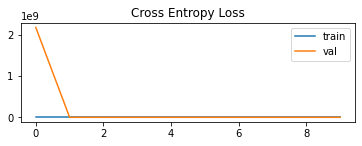

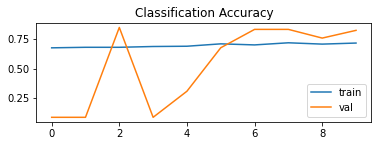

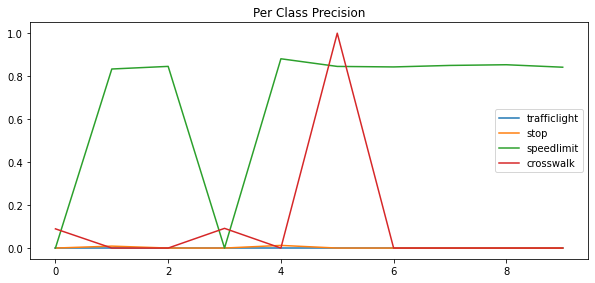

(0.8455284552845529, 'scratch_2')

In [20]:
resnet_model_scratch = models.resnet50(pretrained=False)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_scratch.fc.in_features
resnet_model_scratch.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_scratch.to(device)

resnet_scratch = {
    "model": resnet_model_scratch,
    "name": 'resnet50_scratch',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),
    "optimizer": torch.optim.Adam(resnet_model_scratch.parameters(), lr=0.01),
}

resnet_trainer = ModelTrainer(resnet_scratch, device)
# Unfreeze all layers
resnet_trainer.unfreeze_layers()
resnet_trainer.set_scheduler(torch.optim.lr_scheduler.StepLR, gamma=0.9)

load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)

if not load or need_train:
    resnet_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(resnet_trainer.accuracies, "scratch")
resnet_trainer.get_best_score()

The group was surprised with the results being so high (76%), we were expecting a lower accuracy.

### VGG-16

VGG-16 Expects the same input size and normalization as ResNet-50, so it will be the same. In this brief section we will only train this network two times: with transfer learning and from scratch. This process is the same to what was done with resnet.

Start training...

Epoch 0 - Train loss: 3.340 	 Train acc: 0.580 - Val loss: 0.932 	 Val acc: 0.667

Epoch 1 - Train loss: 1.049 	 Train acc: 0.788 - Val loss: 0.476 	 Val acc: 0.911

Epoch 2 - Train loss: 0.692 	 Train acc: 0.833 - Val loss: 0.820 	 Val acc: 0.862

Epoch 3 - Train loss: 0.421 	 Train acc: 0.888 - Val loss: 0.659 	 Val acc: 0.813

Epoch 4 - Train loss: 0.338 	 Train acc: 0.924 - Val loss: 0.605 	 Val acc: 0.870

Epoch 5 - Train loss: 0.301 	 Train acc: 0.908 - Val loss: 0.605 	 Val acc: 0.829

Epoch 6 - Train loss: 0.190 	 Train acc: 0.938 - Val loss: 0.705 	 Val acc: 0.854

Epoch 7 - Train loss: 0.224 	 Train acc: 0.933 - Val loss: 0.633 	 Val acc: 0.854

Epoch 8 - Train loss: 0.180 	 Train acc: 0.933 - Val loss: 0.574 	 Val acc: 0.894

Epoch 9 - Train loss: 0.167 	 Train acc: 0.942 - Val loss: 0.755 	 Val acc: 0.805
Finished
Start training...

Epoch 10 - Train loss: 0.141 	 Train acc: 0.940 - Val loss: 0.641 	 Val acc: 0.870

Epoch 11 - Train loss: 0.124 	 Train acc

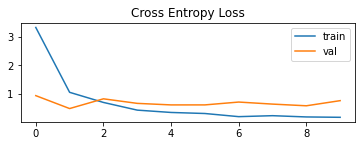

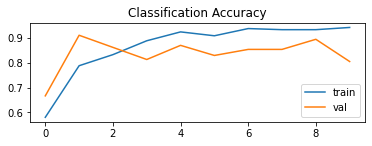

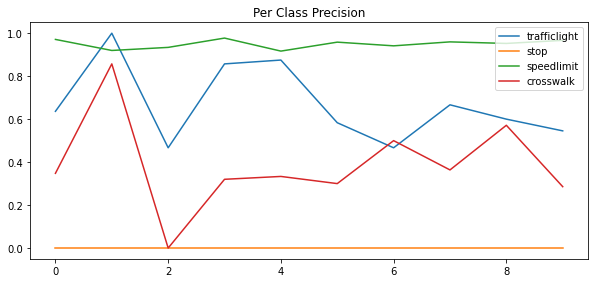

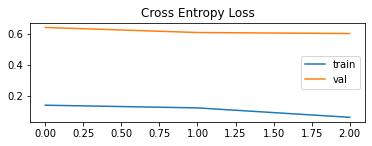

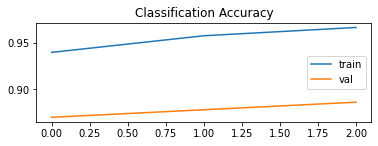

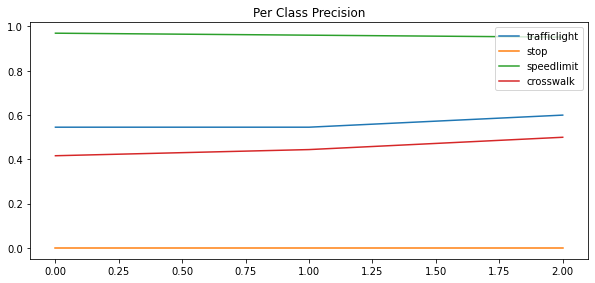

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.841667,0.0,0.821138,0.210417,0.711653
recall,0.0,0.0,0.971154,0.0,0.821138,0.242788,0.821138
f1-score,0.0,0.0,0.901786,0.0,0.821138,0.225446,0.762485
support,7.0,1.0,104.000000,11.0,0.821138,123.000000,123.000000


In [22]:
input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader, test_dataloaders = get_dataloaders(input_size, mean, std, transform_normalize)
vgg_model_pretrained = models.vgg16(pretrained=True)

trainer, vgg_best_score = transfer_learn(
    name="vgg_pretrained_adam_stepLR",
    model=vgg_model_pretrained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_fine_tune=0.9,
    load=False
)
vgg_best_score

Training from scratch

Start training...

Epoch 0 - Train loss: 1.400 	 Train acc: 0.167 - Val loss: 1.396 	 Val acc: 0.089

Epoch 1 - Train loss: 1.397 	 Train acc: 0.183 - Val loss: 1.396 	 Val acc: 0.089

Epoch 2 - Train loss: 1.398 	 Train acc: 0.179 - Val loss: 1.396 	 Val acc: 0.089

Epoch 3 - Train loss: 1.397 	 Train acc: 0.179 - Val loss: 1.396 	 Val acc: 0.089

Epoch 4 - Train loss: 1.398 	 Train acc: 0.161 - Val loss: 1.396 	 Val acc: 0.089

Epoch 5 - Train loss: 1.401 	 Train acc: 0.156 - Val loss: 1.396 	 Val acc: 0.089

Epoch 6 - Train loss: 1.397 	 Train acc: 0.174 - Val loss: 1.396 	 Val acc: 0.089

Epoch 7 - Train loss: 1.395 	 Train acc: 0.165 - Val loss: 1.396 	 Val acc: 0.089

Epoch 8 - Train loss: 1.398 	 Train acc: 0.167 - Val loss: 1.396 	 Val acc: 0.089

Epoch 9 - Train loss: 1.396 	 Train acc: 0.185 - Val loss: 1.396 	 Val acc: 0.089
Finished


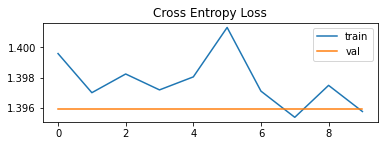

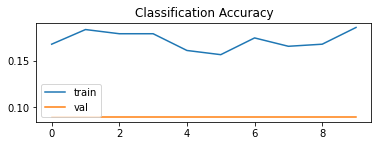

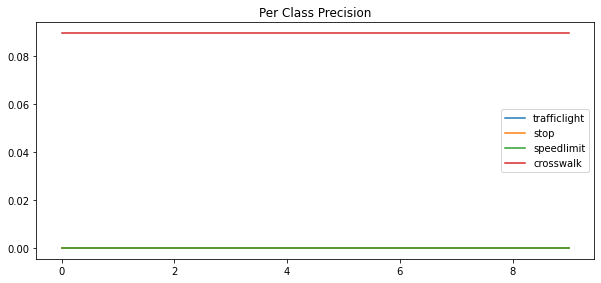

(0.08943089430894309, 'scratch_0')

In [23]:
vgg_model_scratch = models.vgg16(pretrained=False)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
last_item_index = len(vgg_model_scratch.classifier)-1
old_fc = vgg_model_scratch.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features, out_features= num_classes, bias=True)
vgg_model_scratch.classifier.__setitem__(last_item_index , new_fc)
vgg_model_scratch.to(device)

vgg_scratch = {
    "model": vgg_model_scratch,
    "name": 'vgg_scratch',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),
    "optimizer": torch.optim.Adam(resnet_model_scratch.parameters(), lr=0.01),
}

vgg_trainer = ModelTrainer(vgg_scratch, device)
# Unfreeze all layers
vgg_trainer.unfreeze_layers()
vgg_trainer.set_scheduler(torch.optim.lr_scheduler.StepLR, gamma=0.9)

load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(vgg_trainer) == False)
if not load or need_train:
    vgg_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(vgg_trainer.accuracies, "scratch")
vgg_trainer.get_best_score()

As we can see the results were extremly poor. We don't know why there is a huge descrepancy between this value and the accuracy achieved by Resnet from scratch (75%)

## Data Augmentation

The experimented data augmentation methods can be seen bellow. Different combintations were tried, and these were chosen due to them giving better results. 

In [26]:
def transform_data(input_size, mean, std):
    train_transform = A.Compose([
        A.RandomScale(scale_limit=0.5, interpolation=1, p=0.2),
        A.Rotate(limit=40, interpolation=1, p=0.2),
        A.ElasticTransform(p=0.1),
        A.HorizontalFlip(p=0.2),
        A.Downscale(scale_min=0.25, scale_max=0.25, p=0.1),
        A.RandomBrightnessContrast(p=0.2),
        A.OneOf([ # Noise
            A.GaussNoise(p=0.3),
            A.ImageCompression(p=0.2, quality_lower=20, quality_upper=70),
            A.Sharpen(p=0.3)
        ], p=0.2),
        A.OneOf([ # Distortion
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([ # Blurring
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([ # Color
            A.ToGray(p=0.2),
            A.ToSepia(p=0.2),
            A.RGBShift(r_shift_limit=40, g_shift_limit=60, b_shift_limit=40, p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        ], p=0.2),
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
        #A.RandomResizedCrop(input_size, input_size),
        #A.HorizontalFlip(),
    return train_transform, val_transform

input_size = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(input_size, mean, std, transform_data)

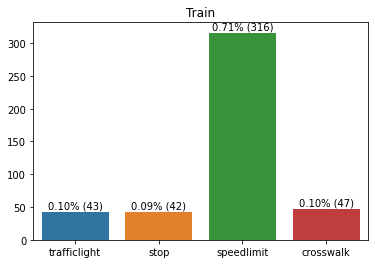

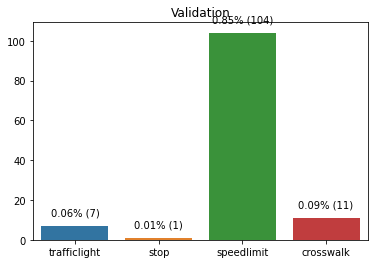

In [27]:
describe_dataloader(train_dataloader, "Train"), describe_dataloader(val_dataloader, "Validation");

Let's add these transformations with the best model, ResNet50 with ADAM and ExpLR with transfer learning.

In [28]:
expLR_best_score

NameError: name 'expLR_best_score' is not defined

Start training...

Epoch 0 - Train loss: 4.337 	 Train acc: 0.520 - Val loss: 0.626 	 Val acc: 0.862

Epoch 1 - Train loss: 2.110 	 Train acc: 0.708 - Val loss: 1.789 	 Val acc: 0.862

Epoch 2 - Train loss: 1.576 	 Train acc: 0.750 - Val loss: 0.380 	 Val acc: 0.911

Epoch 3 - Train loss: 0.696 	 Train acc: 0.763 - Val loss: 0.513 	 Val acc: 0.886

Epoch 4 - Train loss: 0.537 	 Train acc: 0.817 - Val loss: 0.405 	 Val acc: 0.902

Epoch 5 - Train loss: 0.457 	 Train acc: 0.853 - Val loss: 0.374 	 Val acc: 0.919

Epoch 6 - Train loss: 0.370 	 Train acc: 0.879 - Val loss: 0.395 	 Val acc: 0.902

Epoch 7 - Train loss: 0.274 	 Train acc: 0.908 - Val loss: 0.280 	 Val acc: 0.935

Epoch 8 - Train loss: 0.294 	 Train acc: 0.893 - Val loss: 0.352 	 Val acc: 0.919

Epoch 9 - Train loss: 0.298 	 Train acc: 0.911 - Val loss: 0.320 	 Val acc: 0.911
Finished
Start training...

Epoch 10 - Train loss: 0.254 	 Train acc: 0.908 - Val loss: 0.320 	 Val acc: 0.911

Epoch 11 - Train loss: 0.263 	 Train acc

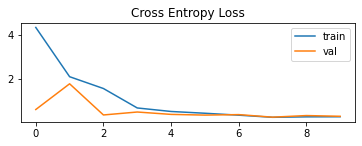

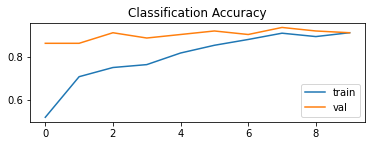

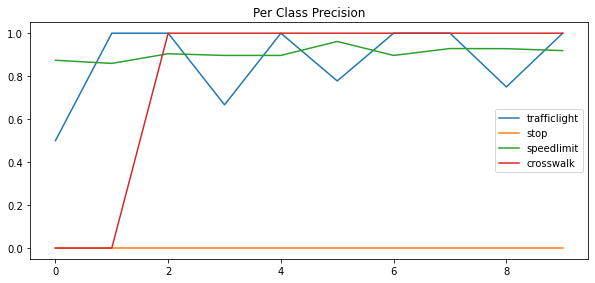

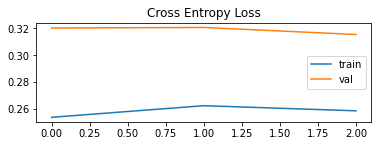

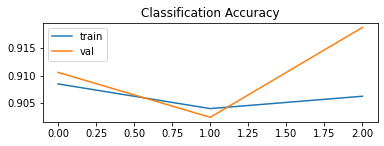

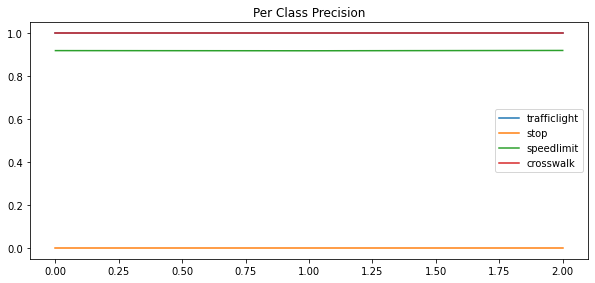

In [30]:
# ExpLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer, data_aug_best_score = transfer_learn(
    name="resnet50_pretrained_adam_expLR_dataloader",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_fine_tune=0.9,
    load=False
)

We can conclude that this greatly improves results, from 85% to 92%

## Custom Architecture

Bellow we define our custom architecture

In [31]:
class CustomCNN(nn.Module):
    def __init__(self, input_size):
        super(CustomCNN, self).__init__()
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3
        flatten_size = (((((input_size - 2 - 2) // 2) - 2 - 2) // 2) ** 2 * self.nb_filters)

        self.layers = nn.Sequential(
            nn.Conv2d(3, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.BatchNorm2d(self.nb_filters),
            nn.Dropout(0.25),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.BatchNorm2d(self.nb_filters),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = CustomCNN(input_size)
model.to(device)
summary(model, (3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
              ReLU-2         [-1, 32, 222, 222]               0
            Conv2d-3         [-1, 32, 220, 220]           9,248
              ReLU-4         [-1, 32, 220, 220]               0
         MaxPool2d-5         [-1, 32, 110, 110]               0
       BatchNorm2d-6         [-1, 32, 110, 110]              64
           Dropout-7         [-1, 32, 110, 110]               0
            Conv2d-8         [-1, 32, 108, 108]           9,248
              ReLU-9         [-1, 32, 108, 108]               0
           Conv2d-10         [-1, 32, 106, 106]           9,248
             ReLU-11         [-1, 32, 106, 106]               0
        MaxPool2d-12           [-1, 32, 53, 53]               0
      BatchNorm2d-13           [-1, 32, 53, 53]              64
          Dropout-14           [-1, 32,

For training, we will be using the optimzer, LR scheduler and data augmentations that have given us the best results.

In [34]:
input_size = 224 # Keeo the same input size
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # And mean & std just for consistency
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(input_size, mean, std, transform_data)

Start training...

Epoch 0 - Train loss: 1.323 	 Train acc: 0.404 - Val loss: 1.347 	 Val acc: 0.691

Epoch 1 - Train loss: 1.332 	 Train acc: 0.359 - Val loss: 1.321 	 Val acc: 0.821

Epoch 2 - Train loss: 1.356 	 Train acc: 0.364 - Val loss: 1.301 	 Val acc: 0.813

Epoch 3 - Train loss: 1.340 	 Train acc: 0.371 - Val loss: 1.287 	 Val acc: 0.748

Epoch 4 - Train loss: 1.319 	 Train acc: 0.391 - Val loss: 1.282 	 Val acc: 0.618

Epoch 5 - Train loss: 1.316 	 Train acc: 0.379 - Val loss: 1.282 	 Val acc: 0.553

Epoch 6 - Train loss: 1.351 	 Train acc: 0.344 - Val loss: 1.283 	 Val acc: 0.512

Epoch 7 - Train loss: 1.330 	 Train acc: 0.371 - Val loss: 1.282 	 Val acc: 0.480

Epoch 8 - Train loss: 1.328 	 Train acc: 0.400 - Val loss: 1.282 	 Val acc: 0.488

Epoch 9 - Train loss: 1.353 	 Train acc: 0.373 - Val loss: 1.284 	 Val acc: 0.472
Finished


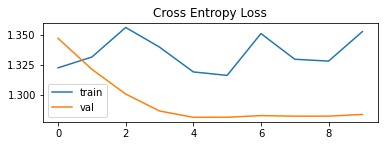

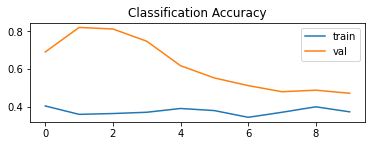

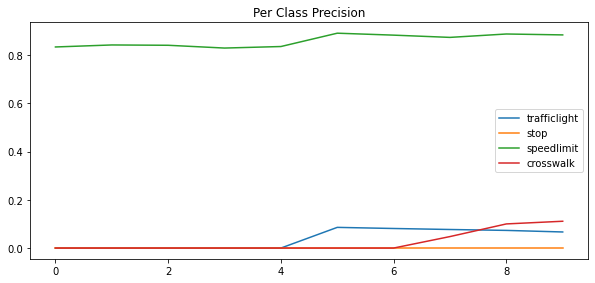

In [35]:
model.to(device)

custom_trained = {
    "model": model,
    "name": 'customCNN',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.Adam(resnet_model_trained.parameters(), lr=1e-2),
}

custom_trainer = ModelTrainer(custom_trained, device)
custom_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
# Unfreeze all layers expect last
custom_trainer.unfreeze_layers()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(custom_trainer) == False)
if not load or need_train:
    need_train = True
    custom_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(custom_trainer.accuracies, "scratch")

As we can see, the results of our custom architecture aren't that satisfactory, the model struggles to achieve a better accuracy value than 20%. We believe that this problem is complex for the number of layers that we used. More layers were experimented with, but the high number of parameters were making the training process too time consuming. 

## Multilabeling
First we need to redefine the dataset to take into consideration multiple labels. Instead of returning the biggest area class, we will be returing what types of signs the image has.

In [36]:
classes # Remember our target classes

{'trafficlight': 0, 'stop': 1, 'speedlimit': 2, 'crosswalk': 3}

In [44]:
class TrafficSignDatasetMultiLabel(TrafficSignDataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self.get_classes_from_annotation(image_filename)

    def get_classes_from_annotation(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            c = torch.zeros(num_classes)
            objects = root.findall("object")
            for object in objects:
                c_name = object.find("name").text
                if c_name in classes and c[classes[c_name]] == 0:
                    c[classes[c_name]] = 1

        return c

input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(input_size, mean, std, transform_normalize)

We will redefine de ModelTrainer class to take into account multiple labels. This implies using a sigmoid in the predictions to map the output vals to a workable range. This will be used to convert the problem into a multiple binary classification problem. For this, we define a threshold probability that is applied for each class to choose if the image prediction contains that class. 

In [45]:
MODELS_DIR = "models"

class ModelTrainerMultiLabel(ModelTrainer):
    def __init__(self, args, device):
        super().__init__(args, device) 

    def _epoch_iter(self, dataloader, is_train, progress_bar=False):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            data = tqdm(dataloader) if progress_bar else dataloader
            for batch, (X, y) in enumerate(data):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                pred = F.sigmoid(pred)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                preds.append(pred.cpu().detach())
                labels.append(y.cpu().detach())

        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        preds = preds.int()
        labels = labels.int()
        acc = accuracy(preds, labels, num_classes=4, average="macro", multiclass=False)

        metrics = {
            'accuracy': acc.item()
        }

        # metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        return total_loss / num_batches, metrics

We will be using the data transformations from the previous section. Mean and std are the same as before because they don't need to vary between Resnet, VGG and our custom architecture

In [46]:
def get_dataloaders_multilabel(input_size, mean, std, transform_f): # Same as above but we use the multilabel dataset
    train_transform, val_transform = transform_f(input_size, mean, std)
    train_dataset = TrafficSignDatasetMultiLabel(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    val_dataset = TrafficSignDatasetMultiLabel(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = get_dataloaders_multilabel(input_size, mean, std, transform_data)

In [47]:
def plotTrainingHistoryMultilabel(accuracies, session): # Only plots accuracy
    session_accs = filter(lambda x: x.startswith(session), accuracies)
    val_loss, val_acc, train_loss, train_acc = [], [], [], []
    for t in session_accs:
        epoch_acc = accuracies[t]
        train_loss.append(epoch_acc["train"]["loss"])
        train_acc.append(epoch_acc["train"]["metrics"]["accuracy"])
        val_loss.append(epoch_acc["val"]["loss"])
        val_acc.append(epoch_acc["val"]["metrics"]["accuracy"])

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend(loc='best')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.legend(loc='best')
    plt.show()

Now we can train the tree networks so far in multilabeling. We will be using the optimizer and LR schedulers that have given best results until now.

Resnet with fine tuning

Start training...

Epoch 0 - Train loss: 1.271 	 Train acc: 0.296 - Val loss: 0.510 	 Val acc: 0.250

Epoch 1 - Train loss: 0.523 	 Train acc: 0.461 - Val loss: 0.500 	 Val acc: 0.247

Epoch 2 - Train loss: 0.408 	 Train acc: 0.386 - Val loss: 0.322 	 Val acc: 0.479

Epoch 3 - Train loss: 0.297 	 Train acc: 0.503 - Val loss: 0.341 	 Val acc: 0.337

Epoch 4 - Train loss: 0.256 	 Train acc: 0.635 - Val loss: 0.281 	 Val acc: 0.357

Epoch 5 - Train loss: 0.224 	 Train acc: 0.603 - Val loss: 0.302 	 Val acc: 0.357

Epoch 6 - Train loss: 0.208 	 Train acc: 0.640 - Val loss: 0.272 	 Val acc: 0.439

Epoch 7 - Train loss: 0.202 	 Train acc: 0.698 - Val loss: 0.290 	 Val acc: 0.343

Epoch 8 - Train loss: 0.196 	 Train acc: 0.687 - Val loss: 0.262 	 Val acc: 0.406

Epoch 9 - Train loss: 0.185 	 Train acc: 0.683 - Val loss: 0.261 	 Val acc: 0.386
Finished
Start training...

Epoch 10 - Train loss: 0.202 	 Train acc: 0.660 - Val loss: 0.260 	 Val acc: 0.386

Epoch 11 - Train loss: 0.183 	 Train acc

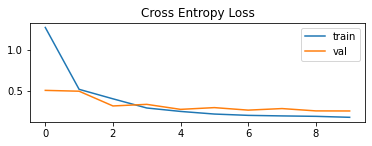

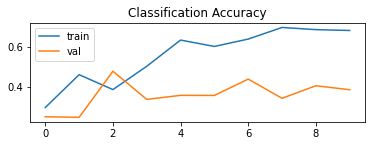

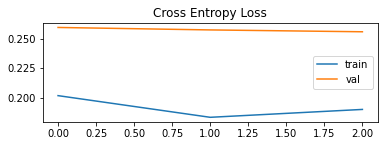

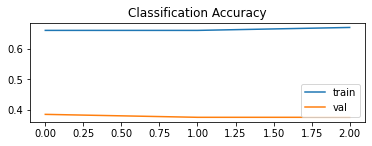

(0.47850680351257324, 'frozen_2')

In [48]:
resnet_model_trained = models.resnet50(pretrained=True)
# number of neurons in the last layer to the number of classes is the same
num_ftrs = resnet_model_trained.fc.in_features
resnet_model_trained.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_trained.to(device)

resnet_trained = {
    "model": resnet_model_trained,
    "name": 'resnet50_multilabel',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.BCELoss(),
    "optimizer": torch.optim.Adam(resnet_model_trained.parameters(), lr=1e-2)
}

resnet_trainer = ModelTrainerMultiLabel(resnet_trained, device)
resnet_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
# Freeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)
if not load or need_train:
    need_train = True
    resnet_trainer.train(train_dataloader, val_dataloader, "frozen")

# Unfreeze all layers - fine tuning
resnet_trainer.optimizer = torch.optim.Adam(resnet_model_trained.parameters(), lr=1e-6)
resnet_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
resnet_trainer.num_epochs = 3
resnet_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    resnet_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistoryMultilabel(resnet_trainer.accuracies, "frozen")
plotTrainingHistoryMultilabel(resnet_trainer.accuracies, "fine_tuning")
resnet_trainer.get_best_score()

Vgg with fine tuning

Start training...

Epoch 0 - Train loss: 1.256 	 Train acc: 0.247 - Val loss: 0.661 	 Val acc: 0.483

Epoch 1 - Train loss: 0.594 	 Train acc: 0.674 - Val loss: 0.550 	 Val acc: 0.324

Epoch 2 - Train loss: 0.442 	 Train acc: 0.518 - Val loss: 0.407 	 Val acc: 0.573

Epoch 3 - Train loss: 0.308 	 Train acc: 0.729 - Val loss: 0.405 	 Val acc: 0.416

Epoch 4 - Train loss: 0.276 	 Train acc: 0.649 - Val loss: 0.359 	 Val acc: 0.516

Epoch 5 - Train loss: 0.229 	 Train acc: 0.784 - Val loss: 0.289 	 Val acc: 0.438

Epoch 6 - Train loss: 0.242 	 Train acc: 0.690 - Val loss: 0.335 	 Val acc: 0.464

Epoch 7 - Train loss: 0.231 	 Train acc: 0.754 - Val loss: 0.305 	 Val acc: 0.445

Epoch 8 - Train loss: 0.214 	 Train acc: 0.702 - Val loss: 0.284 	 Val acc: 0.495

Epoch 9 - Train loss: 0.201 	 Train acc: 0.762 - Val loss: 0.286 	 Val acc: 0.469
Finished
Start training...

Epoch 10 - Train loss: 0.173 	 Train acc: 0.808 - Val loss: 0.284 	 Val acc: 0.459

Epoch 11 - Train loss: 0.183 	 Train acc

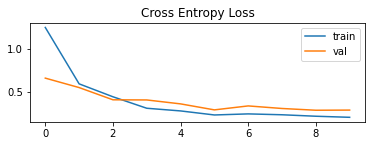

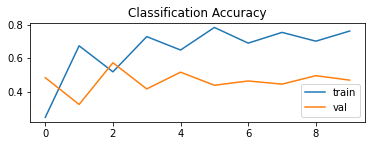

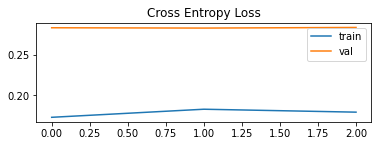

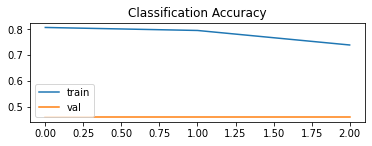

(0.5726756453514099, 'frozen_2')

In [49]:
vgg_model_trained= models.vgg16(pretrained=True)
# number of neurons in the last layer to the number of classes is the same
last_item_index = len(vgg_model_trained.classifier)-1
old_fc = vgg_model_trained.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features, out_features= num_classes, bias=True)
vgg_model_trained.classifier.__setitem__(last_item_index, new_fc)
vgg_model_trained.to(device)

vgg_trained = {
    "model": vgg_model_trained,
    "name": 'vgg_multilabel',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.BCELoss(),
    "optimizer": torch.optim.Adam(vgg_model_trained.parameters(), lr=1e-2)
}

vgg_trainer = ModelTrainerMultiLabel(vgg_trained, device)
vgg_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
# Freeze all layers expect last
vgg_trainer.freeze_layers()
vgg_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(vgg_trainer) == False)
if not load or need_train:
    need_train = True
    vgg_trainer.train(train_dataloader, val_dataloader, "frozen")

# Unfreeze all layers - fine tuning
vgg_trainer.optimizer = torch.optim.Adam(vgg_model_trained.parameters(), lr=1e-6)
vgg_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
vgg_trainer.num_epochs = 3
vgg_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    vgg_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistoryMultilabel(vgg_trainer.accuracies, "frozen")
plotTrainingHistoryMultilabel(vgg_trainer.accuracies, "fine_tuning")
vgg_trainer.get_best_score()

Custom architecture

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 15.273 	 Train acc: 0.323 - Val loss: 12.864 	 Val acc: 0.250

Epoch 1 - Train loss: 16.909 	 Train acc: 0.254 - Val loss: 12.864 	 Val acc: 0.250

Epoch 2 - Train loss: 16.022 	 Train acc: 0.250 - Val loss: 12.864 	 Val acc: 0.250

Epoch 3 - Train loss: 16.797 	 Train acc: 0.250 - Val loss: 12.864 	 Val acc: 0.250

Epoch 4 - Train loss: 16.853 	 Train acc: 0.250 - Val loss: 12.864 	 Val acc: 0.250

Epoch 5 - Train loss: 16.964 	 Train acc: 0.250 - Val loss: 12.864 	 Val acc: 0.250

Epoch 6 - Train loss: 16.797 	 Train acc: 0.250 - Val loss: 12.864 	 Val acc: 0.250

Epoch 7 - Train loss: 16.914 	 Train acc: 0.250 - Val loss: 12.864 	 Val acc: 0.250

Epoch 8 - Train loss: 15.792 	 Train acc: 0.250 - Val loss: 12.864 	 Val acc: 0.250

Epoch 9 - Train loss: 17.188 	 Train acc: 0.250 - Val loss: 12.864 	 Val acc: 0.250
Finished


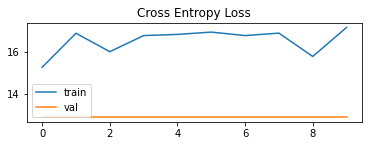

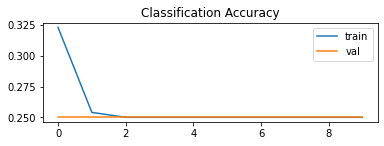

(0.25, 'scratch_0')

In [50]:
custom_model= CustomCNN(input_size)
custom_model.to(device)

custom_model_d = {
    "model": custom_model,
    "name": 'custom_multilabel',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.BCELoss(),
    "optimizer": torch.optim.Adam(custom_model.parameters(), lr=1e-2)
}

custom_trainer = ModelTrainerMultiLabel(custom_model_d, device)
custom_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
custom_trainer.unfreeze_layers()

# Training can be skipped by loading the best model until now
load = True # Change this to False to force to retrain
if load:
    need_train = (load_model(custom_trainer) == False)
if not load or need_train:
    need_train = True
    custom_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistoryMultilabel(custom_trainer.accuracies, "scratch")
custom_trainer.get_best_score()

Similar to the multiclass stage, the custom architecture seems to also struggle in multilabeling.